In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import ngrams, bigrams, trigrams


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
df = pd.read_csv(r'/content/drive/MyDrive/PROJECT/train.csv', encoding='latin-1')

In [3]:
df.columns =['target', 'id', 'date', 'flag', 'user', 'comment_text']
df

,target,id,date,flag,user,comment_text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   target        1599999 non-null  int64 
 1   id            1599999 non-null  int64 
 2   date          1599999 non-null  object
 3   flag          1599999 non-null  object
 4   user          1599999 non-null  object
 5   comment_text  1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df.isnull().sum()

target          0
id              0
date            0
flag            0
user            0
comment_text    0
dtype: int64

In [6]:
df['target'].value_counts()

4    800000
0    799999
Name: target, dtype: int64

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

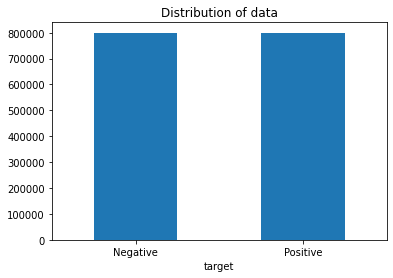

In [ ]:
# Plotting the distribution for dataset
df1 = df[['target', 'comment_text']]
x = df1.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
x.set_xticklabels(['Negative','Positive'], rotation=0)

In [7]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']


In [8]:
# Function for text preprocessing
def preprocess(tweets):
    processed_tweet = []
    
    # Creating Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    username_remove       = '@[^\s]+'
    #The regular expression ((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*) 
    #matches any string that starts with "http://", "https://", or "www.", followed by any number of non-space characters
    url_remove        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"

    #The regular expression [^a-zA-Z0-9] matches any single character that is not a letter (uppercase or lowercase) or a digit.
    non_alpha      = "[^a-zA-Z0-9]"

    #The regular expression (.)\1\1+ matches any sequence of three or more consecutive identical characters.
    pattern   = r"(.)\1\1+"

    #The regular expression \1\1 is a backreference that matches any two consecutive identical characters.
    replace_pattern = r"\1\1"

    #The regular expression \w*\d\w* matches any string that contains at least one digit (\d) 
    #and zero or more word characters (\w) before and after the digit.
    #alphanumeric = '\w*\d\w*'

    #creates a regular expression pattern that matches any single character that is 
    #a member of the punctuation character set defined in the Python string module.
    punc_lower = '[%s]' % re.escape(string.punctuation)

    #The regular expression "\n" matches a newline character in a string.
    remove_n = "\n"

    #The regular expression [^\x00-\x7f] matches any single character that is not a standard ASCII character.
    remove_non_ascii = r'[^\x00-\x7f]'
    
    for tweet in tweets:
        tweet = tweet.lower()
        
        # Replacing all URls with 'URL'
        tweet = re.sub(url_remove,' URL',tweet)

        # Replacing all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])

        # Replacing @USERNAME to 'USER'.
        tweet = re.sub(username_remove,' USER', tweet)

        # Replacing all non alphabets.
        tweet = re.sub(non_alpha, " ", tweet)


        # Replacing alphanumeric
        #tweet = re.sub('\w*\d\w*', ' ', tweet)

        # Replacing punctuation
        tweet = re.sub(punc_lower, ' ', tweet)

        # Replacing \n
        tweet = re.sub(remove_n, " ", tweet)

        # Replacing non-ascii
        tweet = re.sub(remove_non_ascii, r' ', tweet)

        # Replacing 3 or more consecutive letters by 2 letters.
        tweet = re.sub(pattern, replace_pattern, tweet)

        new_tweet = ''
        for word in tweet.split():
            if word not in stopwordlist or len(word) > 1:
                word = wordLemm.lemmatize(word)
                new_tweet += (word+' ')
            
        processed_tweet.append(new_tweet)
        
    return processed_tweet

In [9]:
df['comment_text'] = preprocess(df['comment_text'])
print(f'Text Preprocessing is over!')

Text Preprocessing is over!


In [10]:
Target_comment_df = df.loc[:, ['id','comment_text', 'target']]

In [11]:
Target_comment_df

,id,comment_text,target
0,1467810672,is upset that he can update his facebook by te...,0
1,1467810917,USER dived many time for the ball managed to s...,0
2,1467811184,my whole body feel itchy and like it on fire,0
3,1467811193,USER no it not behaving at all mad why am here...,0
4,1467811372,USER not the whole crew,0
...,...,...,...
1599994,2193601966,just woke up having no school is the best feel...,4
1599995,2193601969,thewdb com very cool to hear old walt intervie...,4
1599996,2193601991,are you ready for your mojo makeover ask me fo...,4
1599997,2193602064,happy 38th birthday to my boo of all time tupa...,4


In [ ]:
# Visualizing dataset using wordcloud
def wordcloud(df, label):
    subset = df[df[label] == 0]
    text = subset.comment_text.values
    wc = WordCloud(background_color = "black", max_words = 2000, width = 1600 , height = 800)
    wc.generate(" ".join(text))
    plt.figure(figsize = (20, 20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize = 20)
    plt.imshow(wc.recolor(colormap = 'gist_earth', random_state = 244), alpha = 0.98)

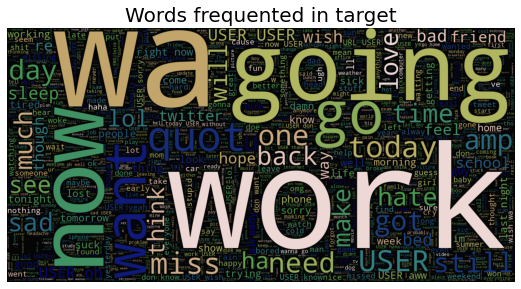

In [ ]:
wordcloud(Target_comment_df, 'target')

In [12]:
Target_comment_df['target'].value_counts()

4    800000
0    799999
Name: target, dtype: int64

In [13]:
Target_comment_df = Target_comment_df.sample(frac=1).reset_index(drop=True)

In [14]:
Target_comment_df.head()

,id,comment_text,target
0,2212863634,USER didn get mine today,0
1,2322022988,USER but then my arm would be naked again,0
2,1962940378,great massage over at the lilac tree spa,4
3,1969394501,got my doug fix yay,4
4,1548643884,USER no support for chrome on freerealms had t...,4


In [15]:
def cv_tf_train_test(dataframe, label, vectorizer, ngram):
    
    # Split the data into X and y data sets
    X = dataframe.comment_text
    y = dataframe[label]
    
    # Split data in train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)
    
    # Using a vectorizer object to create a bag-of-words representation text data.
    cv1 = vectorizer(ngram_range = (ngram),  max_features=500000)
    
    # Transforming x-train and x-test
    X_train_cv1 = cv1.fit_transform(X_train)
    X_test_cv1 = cv1.transform(X_test)
    
    ### ML models
    
    ## logistic regression 
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)

    y_pred = lr.predict(X_test_cv1)
    print("Accuracy LR:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test,y_pred)
    print(conf_mat)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten() / np.sum(conf_mat)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(conf_mat, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix LR", fontdict = {'size':18}, pad = 20)
    plt.show()

    print()
    print()
    
    
    ## Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)

    y_pred = bnb.predict(X_test_cv1)
    print("Accuracy NB:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test,y_pred)
    print(conf_mat)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten() / np.sum(conf_mat)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(conf_mat, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix NB", fontdict = {'size':18}, pad = 20)
    plt.show()

    print()
    print()
    


    ## Multinomial Naive Bayes
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)

    y_pred = mnb.predict(X_test_cv1)
    print("Accuracy MNB:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test,y_pred)
    print(conf_mat)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten() / np.sum(conf_mat)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(conf_mat, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix MNB", fontdict = {'size':18}, pad = 20)
    plt.show()
    print()
    print()

    
    ## Support vector machine
    svm_model = LinearSVC(loss = 'hinge')
    svm_model.fit(X_train_cv1, y_train)

    y_pred = svm_model.predict(X_test_cv1)
    print("Accuracy SVM:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test,y_pred)
    print(conf_mat)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten() / np.sum(conf_mat)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(conf_mat, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix SVM", fontdict = {'size':18}, pad = 20)
    plt.show()
    print()
    print()


    

Accuracy LR: 0.8227208333333333
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    239801
           4       0.82      0.83      0.82    240199

    accuracy                           0.82    480000
   macro avg       0.82      0.82      0.82    480000
weighted avg       0.82      0.82      0.82    480000

[[195135  44666]
 [ 40428 199771]]


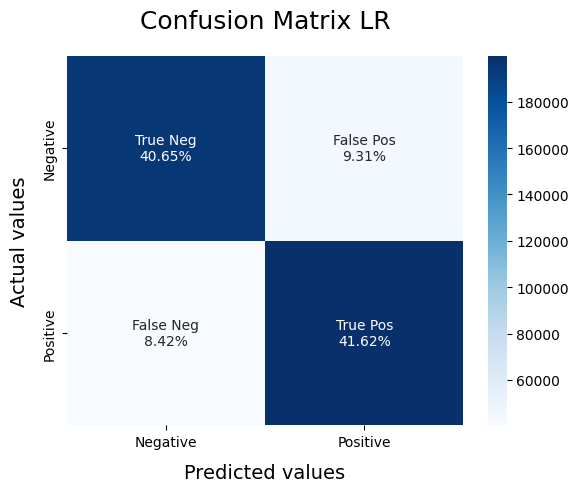



Accuracy NB: 0.80003125
              precision    recall  f1-score   support

           0       0.80      0.79      0.80    239801
           4       0.80      0.81      0.80    240199

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000

[[189942  49859]
 [ 46126 194073]]


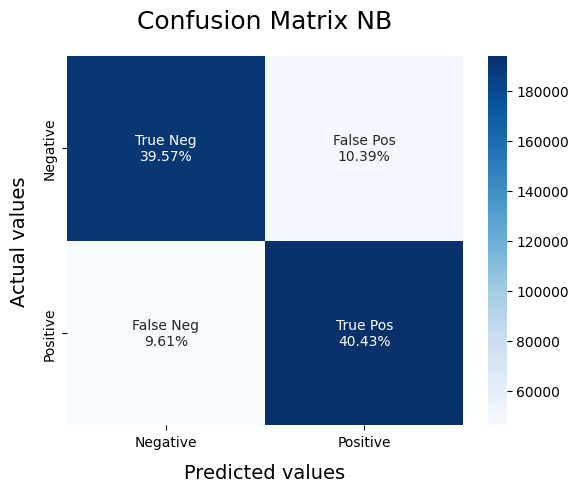



Accuracy MNB: 0.8046270833333333
              precision    recall  f1-score   support

           0       0.80      0.82      0.81    239801
           4       0.81      0.79      0.80    240199

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000

[[195667  44134]
 [ 49645 190554]]


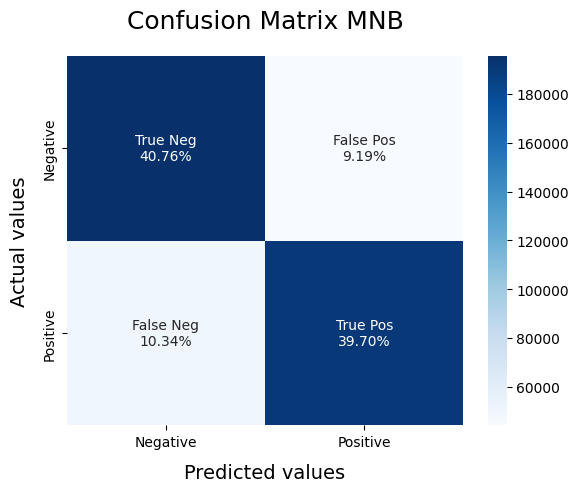



Accuracy SVM: 0.8238166666666666
              precision    recall  f1-score   support

           0       0.83      0.82      0.82    239801
           4       0.82      0.83      0.82    240199

    accuracy                           0.82    480000
   macro avg       0.82      0.82      0.82    480000
weighted avg       0.82      0.82      0.82    480000

[[196156  43645]
 [ 40923 199276]]


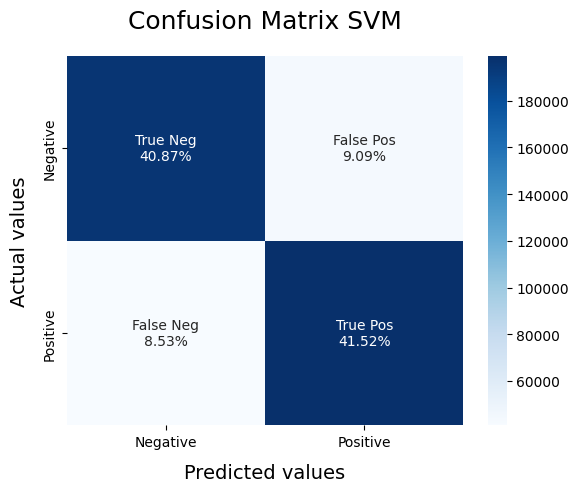

In [16]:
Target_comment_cv = cv_tf_train_test(Target_comment_df, 'target', TfidfVectorizer, (1, 2))

In [17]:
X = Target_comment_df.comment_text
y = Target_comment_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

tfv = TfidfVectorizer(ngram_range = (1,2), stop_words = 'english')
    

X_train_fit = tfv.fit_transform(X_train)
X_test_fit = tfv.transform(X_test)

svm_model = LinearSVC(loss = 'hinge')
svm_model.fit(X_train_fit, y_train)
svm_model.predict(X_test_fit)

array([4, 0, 4, ..., 0, 4, 0])

In [ ]:
#Testing model
c1 = ["I killed the insect and ate it", "I love dogs","I laughed continously till the end, thouroughly enjoyed", "Really funny", "Brave enough to accept the flaws and discuss it openly", "The rabbit one was really deep..", "learn to do comedy then come on stage", "Concept, composition, set up, costumes, every single thing worked 100%..majestic", "Lots of love from India ❤️", "I was expecting more from season 2 as i heard that this time Fuad will lead, but now it seems to me that this season will be the worst than first", "0% understanding \n10000% enjoying", "Bellow coke studio level...."]

In [ ]:
# Testing the model with dummy data
def output_vect(input_comments):
  vect = tfv.transform(preprocess(input_comments))
  return svm_model.predict(vect)

In [ ]:
output_vect(c1)

array([0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4])

In [22]:
"""from joblib import load, dump

dump(tfv, r'/content/drive/MyDrive/PROJECT/vectoriser3.joblib')"""

['/content/drive/MyDrive/PROJECT/vectoriser3.joblib']

In [23]:
import gzip
import pickle

# writing into file. This will take long time
fp = gzip.open(r'/content/drive/MyDrive/PROJECT/vectoriser2.pickle','wb')
pickle.dump(tfv,fp)
fp.close()

file = gzip.open(r'/content/drive/MyDrive/PROJECT/model_dump2.pickle','wb')
pickle.dump(svm_model, file)
file.close()

In [ ]:
"""file = open(r'/content/drive/MyDrive/PROJECT/vectoriser.pickle','wb')
pickle.dump(tfv, file)
file.close()

file = open(r'/content/drive/MyDrive/PROJECT/model_dump.pickle','wb')
pickle.dump(svm_model, file)
file.close()

file = open(r'/content/drive/MyDrive/PROJECT/preprocess_function.pickle','wb')
pickle.dump(preprocess, file)
file.close()"""

In [ ]:
"""def load_predict(text):
    
    # Load the vectoriser.
    file = open('..path/vectoriser.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/model_dump.pickle', 'rb')
    model = pickle.load(file)
    file.close()
    # Load the preprocess function
    file = open('..path/preprocess_function.pickle', 'rb')
    preprocess = pickle.load(file)
    file.close()

     # Predict the sentiment
    vect = vectoriser.transform(preprocess(text))
    sent_array = model.predict(vect)
    
    return sent_array 

   
if __name__=="__main__":
   
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
    
    sent_array = load_predict(text)
    print(sent_array)"""

In [26]:
import zlib, sys

filename_in = r'/content/drive/MyDrive/PROJECT/vectoriser.pickle'
filename_out = r'/content/drive/MyDrive/PROJECT/vectoriser2_compressed.pickle'

with open(filename_in, mode="rb") as fin, open(filename_out, mode="wb") as fout:
    data = fin.read()
    compressed_data = zlib.compress(data, zlib.Z_BEST_COMPRESSION)
    print(f"Original size: {sys.getsizeof(data)}")
    # Original size: 1000033
    print(f"Compressed size: {sys.getsizeof(compressed_data)}")
    # Compressed size: 1024

    fout.write(compressed_data)

filename_in = r'/content/drive/MyDrive/PROJECT/model_dump.pickle'
filename_out = r'/content/drive/MyDrive/PROJECT/model_dump_compressed.pickle'

with open(filename_in, mode="rb") as fin, open(filename_out, mode="wb") as fout:
    data = fin.read()
    compressed_data = zlib.compress(data, zlib.Z_BEST_COMPRESSION)
    print(f"Original size: {sys.getsizeof(data)}")
    # Original size: 1000033
    print(f"Compressed size: {sys.getsizeof(compressed_data)}")
    # Compressed size: 1024

    fout.write(compressed_data)

"""with open(filename_out, mode="rb") as fin:
    data = fin.read()
    compressed_data = zlib.decompress(data)
    print(f"Compressed size: {sys.getsizeof(data)}")
    # Compressed size: 1024
    print(f"Decompressed size: {sys.getsizeof(compressed_data)}")"""

Original size: 105941134
Compressed size: 41199322
Original size: 23897813
Compressed size: 17850384


'with open(filename_out, mode="rb") as fin:\n    data = fin.read()\n    compressed_data = zlib.decompress(data)\n    print(f"Compressed size: {sys.getsizeof(data)}")\n    # Compressed size: 1024\n    print(f"Decompressed size: {sys.getsizeof(compressed_data)}")'